In [70]:
from scipy.io import loadmat
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

import numpy as np
import os
import collections

def my_savefig(file_name):
    plt.savefig(os.path.join(os.getenv('DA_FIGURES', ''), f"{file_name}.pdf"))
    plt.savefig(os.path.join(os.getenv('DA_FIGURES', ''), f"{file_name}.svg"))

def Fr(w, p1, q1, p2, q2):
    cond_1 = w <= -2 * q2 / p2
    expr_1 = p2 * w + q2
    cond_2 = w <= 0
    expr_2 = - p2 ** 2 / (4 * q2) * w ** 2
    cond_3 = w <= 2 * q1 / p1
    expr_3 = p1 ** 2 / (4 * q1) * w ** 2
    cond_4 = True
    expr_4 = p1 * w - q1

    if cond_1:
        return expr_1
    elif cond_2:
        return expr_2
    elif cond_3:
        return expr_3
    elif cond_4:
        return expr_4
    
def load_meas(file_name):
    MeasData = collections.namedtuple('MeasData', ['t', 'vf', 'vb',
                                                   'meas_phi', 'meas_eps', 'meas_lamb',
                                                   'enable_ramping',
                                                   'est_phi', 'est_eps', 'est_lamb',
                                                   'est_dphi', 'est_deps', 'est_dlamb',
                                                   'est_phi_off',
                                                   'traj_t',
                                                   'traj_vf', 'traj_vb',
                                                   'traj_phi', 'traj_eps', 'traj_lamb'])
    
    file = loadmat(f"../matlab/measurements/{file_name}")
    
    traj_t = file['t'].flatten()
    traj_phi = file['phi']
    traj_eps = file['eps']
    traj_lamb = file['lamb']
    traj_vf = file['vf']
    traj_vb = file['vb']
    
    log = file['log']
    
    t = log['time'][0][0].flatten()
    
    values = log['signals'][0][0]['values'][0]
    
    vf = values[0].flatten()
    vb = values[1].flatten()
    meas_phi = values[2].flatten()
    meas_eps = values[3].flatten()
    meas_lamb = values[4].flatten()
    enable_ramping = values[5].flatten() if len(values) >= 6 else np.zeros(len(t))
    est_phi = values[6].flatten() if len(values) >= 7 else np.zeros(len(t))
    est_eps = values[7].flatten() if len(values) >= 8 else np.zeros(len(t))
    est_lamb = values[8].flatten() if len(values) >= 9 else np.zeros(len(t))
    est_dphi = values[9].flatten() if len(values) >= 10 else np.zeros(len(t))
    est_deps = values[10].flatten() if len(values) >= 11 else np.zeros(len(t))
    est_dlamb = values[11].flatten() if len(values) >= 12 else np.zeros(len(t))
    est_phi_off = values[12].flatten() if len(values) >= 13 else np.zeros(len(t))
    
    return MeasData(t, vf, vb, meas_phi, meas_eps, meas_lamb, enable_ramping,
                    est_phi, est_eps, est_lamb, est_dphi, est_deps, est_dlamb, est_phi_off,
                    traj_t, traj_vf, traj_vb, traj_phi, traj_eps, traj_lamb)

def clip_and_unify(meas_data, clip_start=None, clip_end=None, relative_to_traj_start=True, normalize_t=True):
    Clip = collections.namedtuple('Clip', ['t', 'vf', 'vb',
                                           'phi', 'eps', 'lamb',
                                           'dphi', 'deps', 'dlamb',
                                           'traj_vf', 'traj_vb',
                                           'traj_phi', 'traj_eps', 'traj_lamb',
                                           'traj_start', 'traj_end'])
    
    traj_times = meas_data.t[meas_data.enable_ramping == -1]
    traj_start = traj_times[0]
    traj_end = traj_times[-1]
    
    if relative_to_traj_start:
        if clip_start is None:
            clip_start = 0
        else:
            clip_start = clip_start + traj_start
            
        if clip_end is None:
            clip_end = traj_end - traj_start
        else:
            clip_end = clip_end + traj_start
    else:
        if clip_start is None:
            clip_start = traj_start
        if clip_end is None:
            clip_end = traj_end
    
    clip_indices = (meas_data.t >= clip_start) & (meas_data.t <= clip_end)
    clip_t_unnormalized = meas_data.t[clip_indices] 
    if normalize_t:
        clip_t = clip_t_unnormalized - clip_start
        clip_traj_start = traj_start - clip_start
        clip_traj_end = traj_end - clip_start
    else:
        clip_t = clip_t_unnormalized
        clip_traj_start = traj_start
        clip_traj_end = traj_end
    clip_vf = meas.vf[clip_indices]
    clip_vb = meas.vb[clip_indices]
    clip_phi = meas_data.est_phi[clip_indices]
    clip_eps = meas_data.est_eps[clip_indices]
    clip_lamb = meas_data.est_lamb[clip_indices]   
    clip_dphi = meas_data.est_dphi[clip_indices]
    clip_deps = meas_data.est_deps[clip_indices]
    clip_dlamb = meas_data.est_dlamb[clip_indices]
    traj_t_shifted = meas_data.traj_t + traj_start
    
    
    traj_vf_interp = interp1d(traj_t_shifted, meas_data.traj_vf,
                               bounds_error=False, fill_value=(meas_data.traj_vf[0], meas_data.traj_vf[-1]), axis=0)
    clip_traj_vf = traj_vf_interp(clip_t_unnormalized)
    traj_vb_interp = interp1d(traj_t_shifted, meas_data.traj_vb,
                               bounds_error=False, fill_value=(meas_data.traj_vb[0], meas_data.traj_vb[-1]), axis=0)
    clip_traj_vb = traj_vb_interp(clip_t_unnormalized)
    traj_phi_interp = interp1d(traj_t_shifted, meas_data.traj_phi,
                               bounds_error=False, fill_value=(meas_data.traj_phi[0], meas_data.traj_phi[-1]), axis=0)
    clip_traj_phi = traj_phi_interp(clip_t_unnormalized)
    traj_eps_interp = interp1d(traj_t_shifted, meas_data.traj_eps,
                               bounds_error=False, fill_value=(meas_data.traj_eps[0], meas_data.traj_eps[-1]), axis=0)
    clip_traj_eps = traj_eps_interp(clip_t_unnormalized)
    traj_lamb_interp = interp1d(traj_t_shifted, meas_data.traj_lamb,
                               bounds_error=False, fill_value=(meas_data.traj_lamb[0], meas_data.traj_lamb[-1]), axis=0)
    clip_traj_lamb = traj_lamb_interp(clip_t_unnormalized)
    
    return Clip(clip_t, clip_vf, clip_vb,
                clip_phi, clip_eps, clip_lamb,
                clip_dphi, clip_deps, clip_dlamb,
                clip_traj_vf, clip_traj_vb,
                clip_traj_phi, clip_traj_eps, clip_traj_lamb,
                clip_traj_start, clip_traj_end)

def load_est(file_name):
    EstData = collections.namedtuple('EstData', ['params', 'clips'])
    ClipData = collections.namedtuple('ClipData', ['meas_t', 'meas_u', 'meas_y', 'sim_y'])
    
    file = loadmat(f"../matlab/{file_name}")
    
    params = file['params'].flatten()
    clips = []
    
    for i in range(len(file['clips'][0])):
        clip = file['clips'][0,i]
        meas_t = clip['meas_t'].flatten()
        meas_u = clip['meas_u']
        meas_y = clip['meas_y']
        sim_y = clip['sim_y']
        
        clips.append(ClipData(meas_t, meas_u, meas_y, sim_y))
    
    return EstData(params, clips)

deg = np.pi / 180

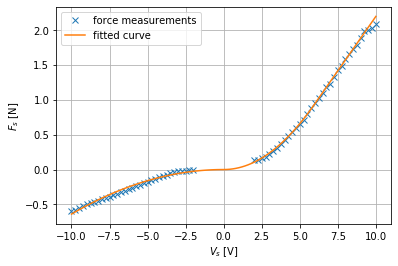

In [4]:
matfile = loadmat('../matlab/rotor_force_analysis/data_for_python')
vsfs_data = matfile['combined_normalized_data']
p1 = float(matfile['p1_opt'])
q1 = float(matfile['q1_opt'])
p2 = float(matfile['p2_opt'])
q2 = float(matfile['q2_opt'])

vs_plot = np.linspace(-10, 10, 101)
Fs_plot = np.array([Fr(vs, p1, q1, p2, q2) for vs in vs_plot])

plt.figure()
plt.plot(vsfs_data[:, 0], vsfs_data[:, 1], 'x', label='force measurements')
plt.plot(vs_plot, Fs_plot, label='fitted curve')
plt.legend()
plt.grid()
plt.xlabel('$V_s$ [V]')
plt.ylabel('$F_s$ [N]')

my_savefig('force_curve')
plt.show()

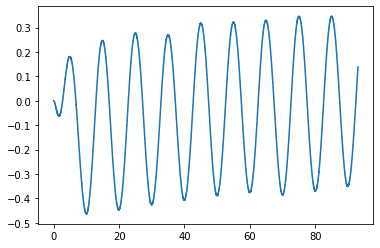

In [10]:
test = load_meas('../parameter_estimation/exp4_lamb_feedback_sine_a20_f0_1.mat')

plt.plot(test.t, test.meas_lamb)

In [76]:
def plot_est(file_name, clip_nr, angle, with_input=True):
    deg = np.pi / 180
    data = load_est(file_name)
    
    if with_input:
        plt.subplot(211)
    plt.plot(data.clips[clip_nr].meas_t, data.clips[clip_nr].meas_y/deg, label='measured')
    plt.plot(data.clips[clip_nr].meas_t, data.clips[clip_nr].sim_y/deg, label='simulated')
    plt.xlabel('$t$ [s]')
    plt.ylabel(f"$\\{angle}$ [°]")
    plt.grid()
    plt.legend()
    
    if with_input:
        plt.subplot(212)
        plt.plot(data.clips[clip_nr].meas_t, data.clips[clip_nr].meas_u)
        plt.xlabel('$t$ [s]')
        plt.ylabel('$V$ [V]')
        plt.grid()
        plt.legend(['$V_f$', '$V_b$'])

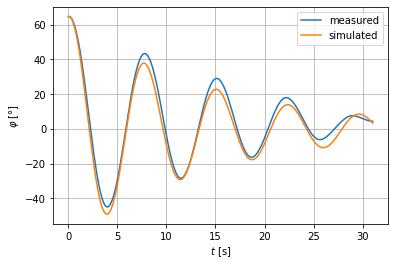

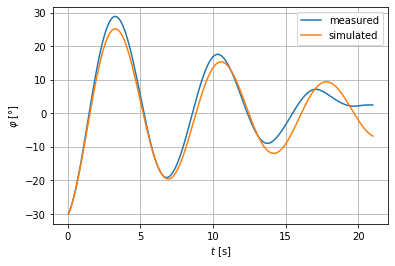

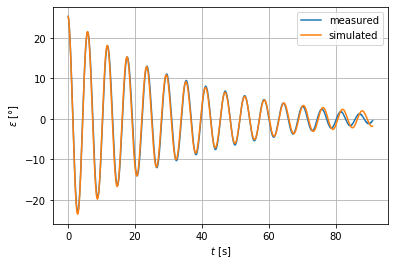

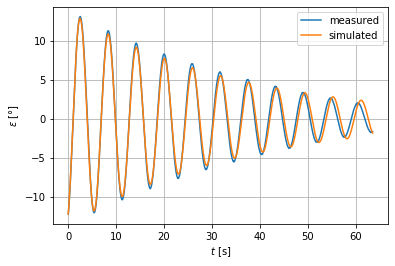

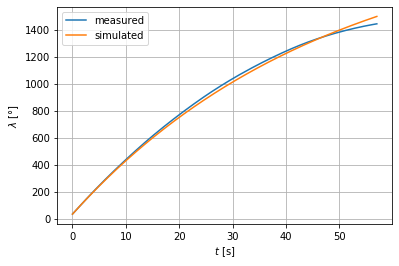

In [82]:
plt.figure()
plot_est('est_mu_phi.mat', 0, 'varphi', False)
my_savefig('est_mu_phi_0')

plt.figure()
plot_est('est_mu_phi.mat', 1, 'varphi', False)
my_savefig('est_mu_phi_1')

plt.figure()
plot_est('est_mu_eps.mat', 0, 'varepsilon', False)
my_savefig('est_mu_eps_0')

plt.figure()
plot_est('est_mu_eps.mat', 1, 'varepsilon', False)
my_savefig('est_mu_eps_1')

plt.figure()
plot_est('est_mu_lamb.mat', 0, 'lambda', False)
my_savefig('est_mu_lamb')

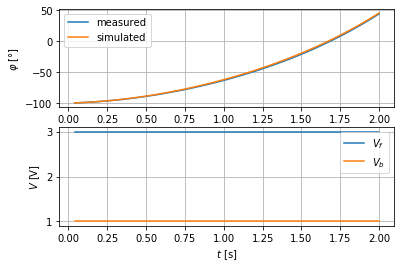

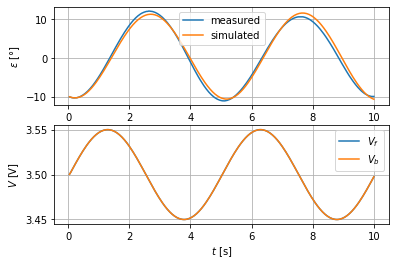

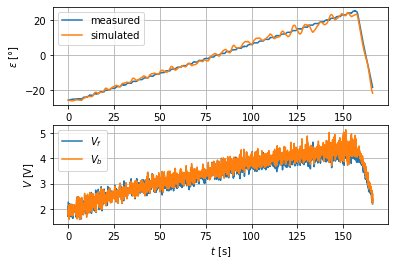

In [93]:
# p_eps_1: good looking 58, 57, 53, 
# p_eps_2 and p_eps_3: 2

plt.figure()
plot_est('est_p_phi_1_p_phi_2.mat', 3, 'varphi', True)
my_savefig('est_p_phi_1_p_phi_2_clip_3')

plt.figure()
plot_est('est_p_eps_1.mat', 53, 'varepsilon', True)
my_savefig('est_p_eps_1_clip_53')

plt.figure()
plot_est('est_p_eps_2_p_eps_3_NICE.mat', 0, 'varepsilon', True)
my_savefig('est_p_eps_2_p_eps_3_NICE')

In [54]:
def label_and_stuff(label_y=True, legend=True):
    plt.grid()
    if legend:
        plt.legend()
    plt.xlabel("$t$ [s]")
    if label_y:
        plt.ylabel("angle [°]")

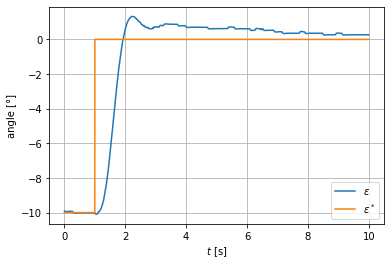

In [22]:
meas = load_meas('pid_1.1_HIGH')
clip = clip_and_unify(meas, -1, 9)

plt.figure()
plt.plot(clip.t, clip.eps/deg, label="$\\varepsilon$")
eps_traj = np.array([-10*deg if t < clip.traj_start else 0 for t in clip.t])
plt.plot(clip.t, eps_traj/deg, label="$\\varepsilon^*$")
label_and_stuff()
my_savefig('pid_1.1')

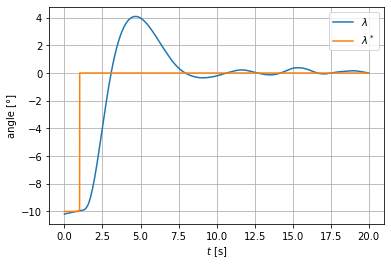

In [26]:
meas = load_meas('pid_1.2.2_LOW')
clip = clip_and_unify(meas, -1, 19)

plt.figure()
plt.plot(clip.t, clip.lamb/deg, label="$\\lambda$")
lamb_traj = np.array([-10*deg if t < clip.traj_start else 0 for t in clip.t])
plt.plot(clip.t, lamb_traj/deg, label="$\\lambda^*$")
label_and_stuff()
my_savefig('pid_1.2.2')

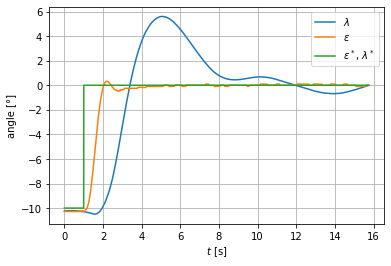

In [27]:
meas = load_meas('pid_1.3_LOW')
clip = clip_and_unify(meas, -1, 29)

plt.figure()
plt.plot(clip.t, clip.lamb/deg, label="$\\lambda$")
plt.plot(clip.t, clip.eps/deg, label="$\\varepsilon$")
eps_lamb_traj = np.array([-10*deg if t < clip.traj_start else 0 for t in clip.t])
plt.plot(clip.t, eps_lamb_traj/deg, label="$\\varepsilon^*$, $\\lambda^*$")
label_and_stuff()
my_savefig('pid_1.3')

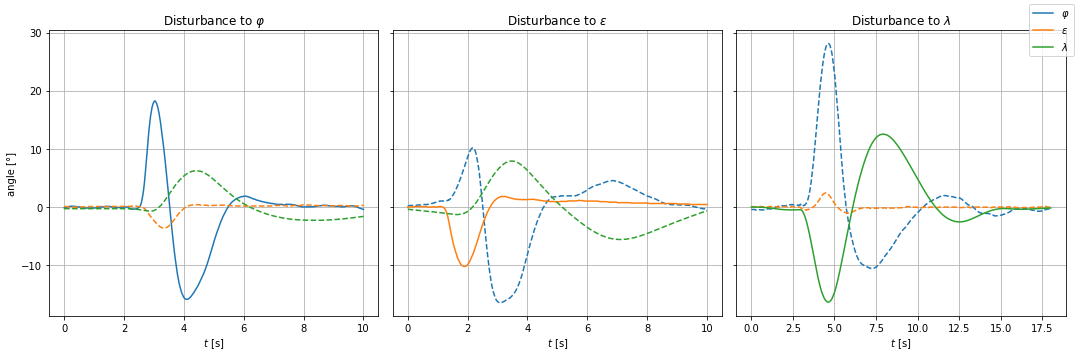

In [82]:
#plt.subplots(1, 3, sharey=True, figsize=(15, 5))
fig = plt.figure(figsize=(15, 5))

ax1 = plt.subplot(131)
meas = load_meas('pid_1.4_2_LOW')
clip = clip_and_unify(meas, 105, 115, False)
plt.plot(clip.t, clip.phi/deg, label="$\\varphi$")
plt.plot(clip.t, clip.eps/deg, linestyle='--')
plt.plot(clip.t, clip.lamb/deg, linestyle='--')
label_and_stuff(legend=False)
plt.title('Disturbance to $\\varphi$')

plt.subplot(132, sharey=ax1)
clip = clip_and_unify(meas, 22.5, 32.5, False)
plt.plot(clip.t, clip.phi/deg, linestyle='--')
plt.plot(clip.t, clip.eps/deg, label="$\\varepsilon$")
plt.plot(clip.t, clip.lamb/deg, linestyle='--')
label_and_stuff(label_y=False, legend=False)
plt.title('Disturbance to $\\varepsilon$')

plt.subplot(133, sharey=ax1)
clip = clip_and_unify(meas, 52, 70, False)
plt.plot(clip.t, clip.phi/deg, linestyle='--')
plt.plot(clip.t, clip.eps/deg, linestyle='--')
plt.plot(clip.t, clip.lamb/deg, label="$\\lambda$")
label_and_stuff(label_y=False, legend=False)
plt.title('Disturbance to $\\lambda$')

for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass

fig.legend()
plt.tight_layout()

my_savefig('pid_1.4')

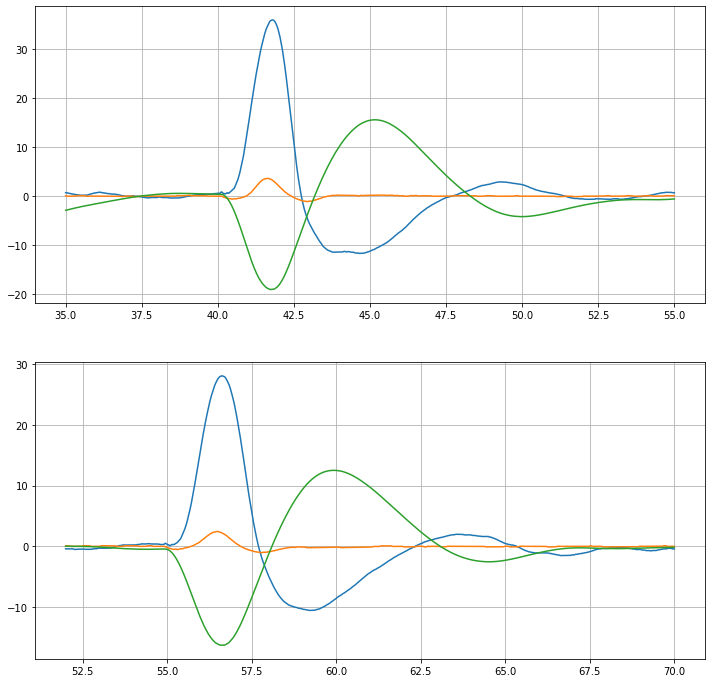

In [73]:
plt.figure(figsize=(12, 12))
meas = load_meas('pid_1.4_LOW')
clip = clip_and_unify(meas, 35, 55, False, False)
plt.subplot(211)
plt.plot(clip.t, clip.phi/deg)
plt.plot(clip.t, clip.eps/deg)
plt.plot(clip.t, clip.lamb/deg)
plt.grid()

meas = load_meas('pid_1.4_2_LOW')
clip = clip_and_unify(meas, 52, 70, False, False)
plt.subplot(212)
plt.plot(clip.t, clip.phi/deg)
plt.plot(clip.t, clip.eps/deg)
plt.plot(clip.t, clip.lamb/deg)
plt.grid()